In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

os.chdir("/nfs/a319/gy17m2a/PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/RobertoProfiles")

In [39]:
# Plot rainfall rates (mm/hr) and cumulative rainfall
# for a multi-peak simulation
# Use 1-minute time steps

## NOTE: CURVES ARE CURRENTLY NOT WRITTEN TO TEXT

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from datetime import datetime


def make_peak(total_duration_minutes,peak_duration,peak_mm_accum,peak_time,peak_shape):
    a_sum=0.1
    b_sum=0.815
    if(peak_shape=='refh2-summer'):
        peak_accum_curve_mm=np.zeros(total_duration_minutes+1)
        for time in range(total_duration_minutes+1):
            # calculate normalised time, -1 being start and 1 end of peak
            n_time=2.0*(time-peak_time)/peak_duration
            if(n_time<-1.0):
                peak_accum_curve_mm[time]=0.0
            elif(n_time>1.0):
                peak_accum_curve_mm[time]=peak_mm_accum
            else:
                peak_accum_curve_mm[time]=peak_mm_accum*(0.5+np.sign(n_time)*0.5*(1-a_sum**((np.abs(n_time))**b_sum))/(1-a_sum))
    else:
        raise Exception('Peak shape not defined')
    return peak_accum_curve_mm

# This subroutine calculates the
# In principle, accommodate for peaks with different shapes
def make_peaks(total_duration_minutes,peak_durations,peak_mm_accums,peak_times,peak_shapes):
    total_accum=np.zeros(total_duration_minutes+1)
    for i_peak in range(len(peak_durations)):
        peak_duration=peak_durations[i_peak]
        peak_mm_accum=peak_mm_accums[i_peak]
        peak_time=peak_times[i_peak]
        peak_shape=peak_shapes[i_peak]
        total_accum=total_accum+make_peak(total_duration_minutes,peak_duration,peak_mm_accum,peak_time,peak_shape)
    return total_accum

def calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes):
    subpeak_mm_accum=total_mm_accum/N_subpeaks
    if(subpeak_duration_minutes*N_subpeaks>total_duration_minutes and method=='divide-time'):
        print(f"Total length of subpeaks longer than total_duration, divide-time method not sensible")
        return
    if(method=='single-peak'):
        # accumulation curve following REFH2 methodology.
        peak_durations=[total_duration_minutes]
        peak_mm_accums=[total_mm_accum]
        peak_times=[total_duration_minutes/2.] #central times
        peak_shapes=[default_peak_shape]
    elif(method=='divide-time'):
        # accumulation: first peak starts at start, last peak ends at end
        peak_durations=[subpeak_duration_minutes]*N_subpeaks
        peak_mm_accums=[subpeak_mm_accum]*N_subpeaks
        peak_times=(total_duration_minutes/(2.*N_subpeaks))*(1+2.0*np.array(range(N_subpeaks)))
        peak_shapes=[default_peak_shape]*N_subpeaks
    elif(method=='max-spread'):
        # accumulation: peaks equally spaced over period
        peak_durations=[subpeak_duration_minutes]*N_subpeaks
        peak_mm_accums=[subpeak_mm_accum]*N_subpeaks
        peak_times=subpeak_duration_minutes/2.0+((total_duration_minutes-subpeak_duration_minutes)/(N_subpeaks-1))*(np.array(range(N_subpeaks)))
        peak_shapes=[default_peak_shape]*N_subpeaks
    elif(method=='subpeak-timing'):
        # accumulation: peak timing calculated so that Nth part of rainfall
        # falls on average at the same time as in the single peak
        # consider each minute as a block with constant rainfall rate for simplicity
        peak_durations=[subpeak_duration_minutes]*N_subpeaks
        peak_mm_accums=[subpeak_mm_accum]*N_subpeaks
        peak_shapes=[default_peak_shape]*N_subpeaks
        # calculate the single peak, as a reference
        ref_accum=make_peak(total_duration_minutes,total_duration_minutes,total_mm_accum,total_duration_minutes/2.,default_peak_shape)
        # calculate peak times for each peak individually
        peak_times=np.zeros(N_subpeaks)
        for i_peak in range(len(peak_durations)):
            accum_start_peak=i_peak*subpeak_mm_accum
            accum_end_peak=(i_peak+1)*subpeak_mm_accum
            prec_time_total=0.
            for time in range(total_duration_minutes):
                time_left=time
                time_right=time+1
                ref_accum_left=ref_accum[time_left]
                ref_accum_right=ref_accum[time_right]
                # fully outside time
                if(ref_accum_left>=accum_end_peak or ref_accum_right<=accum_start_peak):
                    pass
                elif(ref_accum_left>=accum_start_peak and ref_accum_right<=accum_end_peak):
                    # minute fully within peak
                    prec_time_total=prec_time_total+(ref_accum_right-ref_accum_left)*0.5*(time_left+time_right)
                elif(ref_accum_left<=accum_start_peak and ref_accum_right>=accum_start_peak):
                    # this is at the start of peak
                    time_frac=(ref_accum_right-accum_start_peak)/(ref_accum_right-ref_accum_left)
                    time_start_peak=time_right-time_frac
                    prec_time_total=prec_time_total+(ref_accum_right-accum_start_peak)*0.5*(time_start_peak+time_right)
                elif(ref_accum_left<=accum_end_peak and ref_accum_right>=accum_end_peak):
                    # end of peak
                    time_frac=(accum_end_peak-ref_accum_left)/(ref_accum_right-ref_accum_left)
                    time_end_peak=time+time_frac
                    prec_time_total=prec_time_total+(accum_end_peak-ref_accum_left)*0.5*(time_left+time_end_peak)
                else:
                    raise Exception('Unexpected condition in subpeak-timing routine')
            # calculate average time of rainfall arrival
            peak_times[i_peak]=prec_time_total/(accum_end_peak-accum_start_peak)
    accum=make_peaks(total_duration_minutes,peak_durations,peak_mm_accums,peak_times,peak_shapes)
    rate=(accum[1:]-accum[:-1])*60. # convert to mm/hr
    return accum,rate

########################################################
########################################################
#### Function to create a plot with 2 subplots:
#### One containing the accumulation over time, for all 4 methods
#### The other containing the rate over time, for all 4 methods
########################################################
########################################################  
def pdf_plotter():
    fig, axs = plt.subplots(2,1)
    for method in methods:
        accum,rate=calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
        # WRITING TO TEXT COULD BE DONE HERE
        # NOTE ACCUM ARRAY IS 1 LONGER THAN RATE ARRAY
        axs[0].plot(np.array(range(total_duration_minutes+1)),accum)
        axs[1].plot(np.array(range(total_duration_minutes))+0.5,rate)
    axs[0].set_title('Experiment with '+str(N_subpeaks)+' peaks of '+str(subpeak_duration_minutes)+' minutes each in '+str(total_duration_minutes)+' minutes')
    axs[0].legend(methods,loc='lower right')
    axs[0].set_ylabel('rainfall accumulation [mm]')
    axs[1].set_ylabel('rainfall rate [mm/hr]')
    axs[1].set_xlabel('time [mins]')
    plt.tight_layout()
    plt.show()
    
########################################################
########################################################
#### Function to plot the rate plot individually for each
#### of the methods
########################################################
########################################################  
def pdf_plotter_rate(method):
    fig, ax = plt.subplots()
    accum,rate=calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
    # WRITING TO TEXT COULD BE DONE HERE
    # NOTE ACCUM ARRAY IS 1 LONGER THAN RATE ARRAY
    ax.plot(np.array(range(total_duration_minutes))+0.5,rate, linestyle = 'solid', color = 'green', 
            linewidth = 5)
    #axs[0].set_title('Experiment with '+str(N_subpeaks)+' peaks of '+str(subpeak_duration_minutes)+' minutes each in '+str(total_duration_minutes)+' minutes')
    ax.set_ylabel('rainfall rate [mm/hr]')
    ax.set_xlabel('time [mins]')
    plt.tight_layout()
    plt.show()

########################################################
########################################################
#### Create one plot with 4 stacked subplots
#### with each subplot containing the rate plot for each method
########################################################
########################################################    
def pdf_plotter_all_rates():
    fig, axs = plt.subplots(4,1, figsize = (5,6), sharey= True, sharex=True)
    for i in range(0,len(methods)):
        print(i)
        accum,rate=calc_rainfall_curves(methods[i],total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
        # WRITING TO TEXT COULD BE DONE HERE
        # NOTE ACCUM ARRAY IS 1 LONGER THAN RATE ARRAY
        axs[i].plot(np.array(range(total_duration_minutes))+0.5,rate)
    #axs[3].set_title('Experiment with '+str(N_subpeaks)+' peaks of '+str(subpeak_duration_minutes)+' minutes each in '+str(total_duration_minutes)+' minutes')
    #axs[0].legend(methods,loc='lower right')
        #axs[i].set_ylabel('rainfall rate [mm/hr]')
    #axs[3].set_xlabel('time [mins]')
    fig.text(0.5, 0.0, 'Time [mins]', ha='center', fontsize = 12)
    fig.text(0.0, 0.5, 'Rainfall rate [mm/hr]', va='center', rotation='vertical', fontsize = 12)
    plt.tight_layout()
    #plt.savefig("CatchmentAnalysis/CreateSyntheticRainfallEvents/LinDyke_DataAndFigs/SyntheticEvents_preLossRemoval/{}/{}_allmethods.jpg".format(duration,duration))
    plt.show()

single-peak 6h
1.0956277117199775
3
2
1


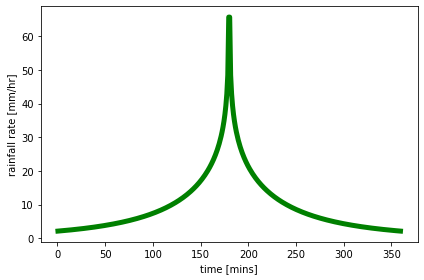

In [40]:
## DIFFERENT METHODS EXPLORED IN SCRIPT
methods=['single-peak']
durations = ['1h', '3h', '6h']

# For each method produce a dataframe containing precipitation values for each minute
# and save these to file
for duration in ['6h']:
    for method in methods:
        print(method, duration)
        
        ## PARAMETER SETTINGS
        N_subpeaks= 3
        total_duration_minutes= int(duration[0]) * 60
        subpeak_duration_minutes=total_duration_minutes/6
        if duration == '1h':
            total_mm_accum= 38.7
        elif duration == '3h':
            total_mm_accum= 51.3
        elif duration == '6h':
              total_mm_accum= 59.98
        default_peak_shape='refh2-summer'
        
        # Create datetimes to go with values
        start = datetime(2022,4,5,0,0,0)
        end = start + relativedelta(hours=int(duration[0]))
        seconds = (end - start).total_seconds() + 60
        step = timedelta(minutes=1)
        datetimes = []
        for i in range(0, int(seconds), int(step.total_seconds())):
            datetimes.append(start + timedelta(seconds=i))       
        
        # Find accumulation and rate
        accum,rate=calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
        # Make rate same length as accumulation 
        rate = np.insert(rate, 0, 0, axis=0)
        # Create as dataframe
        accum_df = pd.DataFrame({'Dates': datetimes,  'Accumulation': accum, 
                                 'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
        # Keep only columns needed for feeding to ReFH2
        accum_df = accum_df[['Dates','Rate (mm/min)']]
        
        
        print(accum_df['Rate (mm/min)'].max())
        
## Antecedent conditions
dates = []
for i in[3,2,1]:
    print(i)
    dates.append(accum_df['Dates'][0] - timedelta(days=i))

antecedent_rainfall = pd.DataFrame({'Date': dates, "rainfall":0.51})
# antecedent_rainfall.to_csv("LinDyke_DataAndFigs/lindyke_daily_antecedent_conditions.csv", index = False)   

#############################################################################
#############################################################################
# Plot
#############################################################################
#############################################################################
# Plot for each method
for method in methods:
    pdf_plotter_rate(method)

# # Plot
# pdf_plotter_all_rates()

    
# # Plot
# pdf_plotter()


In [2]:
total_event_rainfall = 59.98

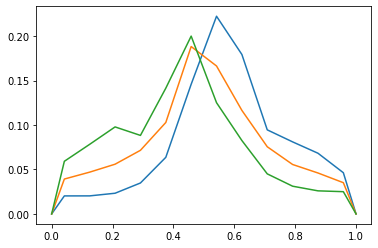

In [3]:
profiles = pd.read_csv("kmeans_15clustersPerDur.csv")

# Just 6hr profiles
profiles_6h = profiles[profiles['Duration'] =='[2:10 - 6:45) hr']
# Just centrally peaked profiles
profiles_6h_c = profiles_6h[profiles_6h['Profile_shape'] == 'C']
#  Just intensity
profiles_6h_c_irain = profiles_6h_c[profiles_6h_c['Variable'] == 'irain']
# Proportion
profiles_6h_c_prain = profiles_6h_c[profiles_6h_c['Variable'] == 'prain']

for cluster_number in profiles_6h_c_prain['Cluster'].unique():
    cluster = profiles_6h_c_prain[profiles_6h_c_prain['Cluster']==cluster_number]
    cluster = cluster.sort_values(by=['Dur_bins'])

    plt.plot(cluster['Dur_bins'], cluster['Mean'], linestyle = 'solid')
plt.show()

In [30]:
profiles_6h_prain = profiles_6h[profiles_6h['Variable'] == 'prain']

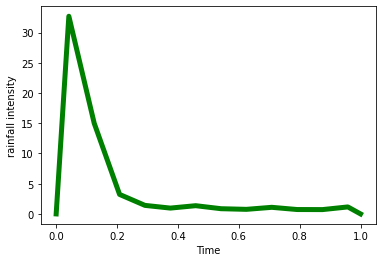

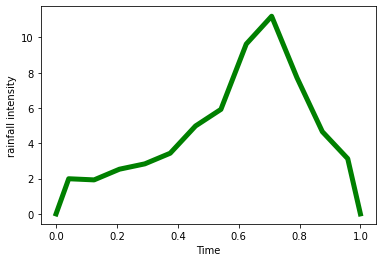

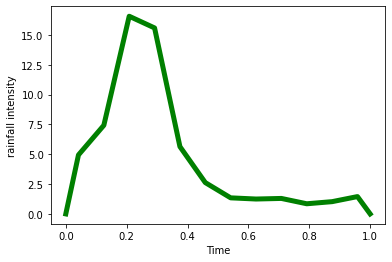

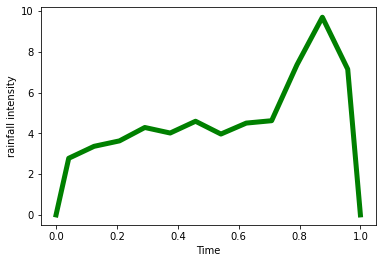

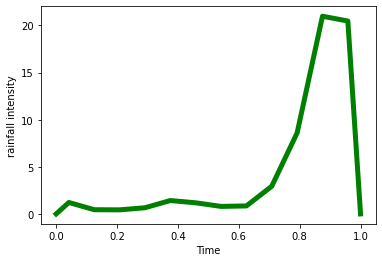

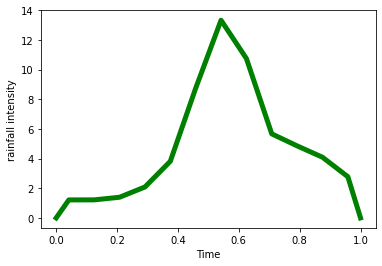

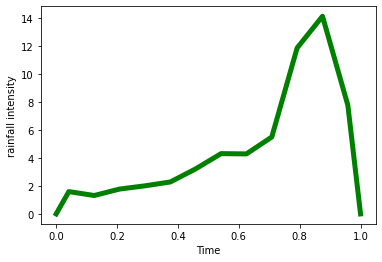

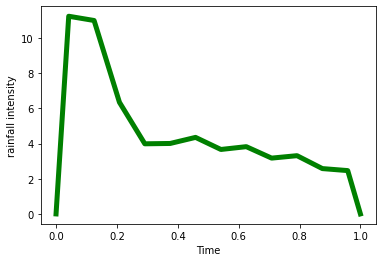

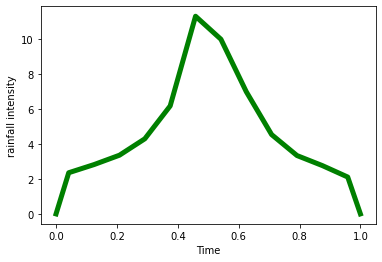

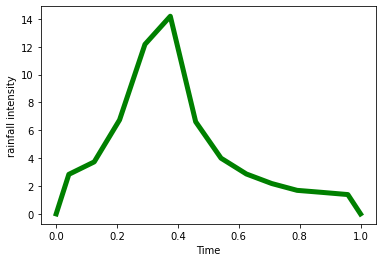

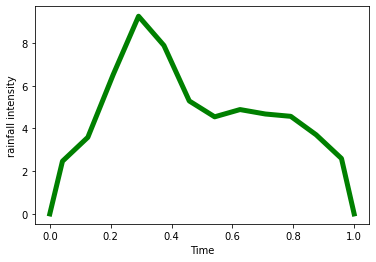

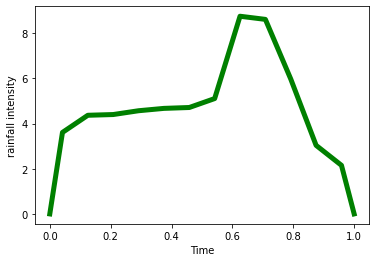

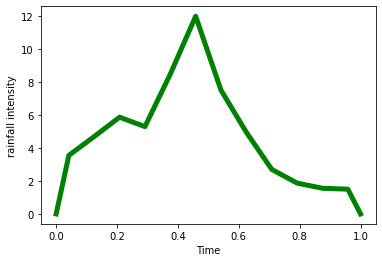

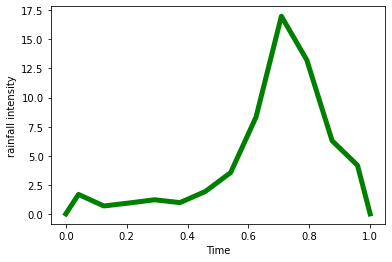

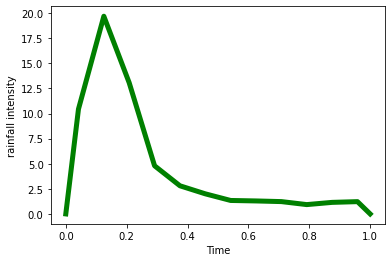

In [35]:
for cluster_number in profiles['Cluster'].unique():
    # Extract data for just this cluster
    cluster = profiles_6h_prain[profiles_6h_prain['Cluster']==cluster_number].copy()
    # Add rainfall per duration bin column
    cluster['rainfall_this_dur_bin'] = cluster['Mean'] * total_event_rainfall
    # Sort by 
    cluster = cluster.sort_values(by=['Dur_bins'])
    # Save to file
    #cluster.to_csv("LinDykeProfiles/6hr_100yrRP/cluster{}.csv".format(cluster_number), index = False)
    # Add line to plot
    fig,ax = plt.subplots()
    plt.plot(cluster['Dur_bins'], cluster['rainfall_this_dur_bin'], linestyle = 'solid', color = 'green', 
            linewidth = 5)
    plt.xlabel("Time")
    plt.ylabel("rainfall intensity")
plt.show()

In [4]:
pwd

'/nfs/a319/gy17m2a/PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/RobertoProfiles'

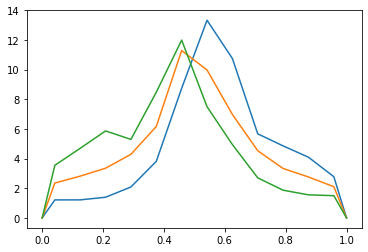

In [5]:
for cluster_number in profiles_6h_c_prain['Cluster'].unique():
    # Extract data for just this cluster
    cluster = profiles_6h_c_prain[profiles_6h_c_prain['Cluster']==cluster_number].copy()
    # Add rainfall per duration bin column
    cluster['rainfall_this_dur_bin'] = cluster['Mean'] * total_event_rainfall
    # Sort by 
    cluster = cluster.sort_values(by=['Dur_bins'])
    # Save to file
    cluster.to_csv("LinDykeProfiles/6hr_100yrRP/cluster{}.csv".format(cluster_number), index = False)
    # Add line to plot
    plt.plot(cluster['Dur_bins'], cluster['rainfall_this_dur_bin'], linestyle = 'solid')
plt.show()

In [18]:
import datetime

d = datetime.date(2022, 1, 1)

# date = pd.date_range(start = d, periods = 12, freq='30T').tolist()




cluster['date'] = pd.date_range(start = d, periods = 14, freq='30T').tolist()
cluster

,Cluster,Dur_bins,Variable,Mean,Duration,Profile_shape,Cluster_id,rainfall_this_dur_bin,date
1837,13,0.000000,prain,0.000000,[2:10 - 6:45) hr,C,13-B,0.000000,2022-01-01 00:00:00
1693,13,0.041667,prain,0.059206,[2:10 - 6:45) hr,C,13-B,3.551175,2022-01-01 00:30:00
1696,13,0.125000,prain,0.078310,[2:10 - 6:45) hr,C,13-B,4.697062,2022-01-01 01:00:00
1699,13,0.208333,prain,0.097864,[2:10 - 6:45) hr,C,13-B,5.869894,2022-01-01 01:30:00
1702,13,0.291667,prain,0.088317,[2:10 - 6:45) hr,C,13-B,5.297258,2022-01-01 02:00:00
1705,13,0.375000,prain,0.141452,[2:10 - 6:45) hr,C,13-B,8.484307,2022-01-01 02:30:00
1708,13,0.458333,prain,0.200013,[2:10 - 6:45) hr,C,13-B,11.996769,2022-01-01 03:00:00
1711,13,0.541667,prain,0.125105,[2:10 - 6:45) hr,C,13-B,7.503787,2022-01-01 03:30:00
1714,13,0.625000,prain,0.082535,[2:10 - 6:45) hr,C,13-B,4.950464,2022-01-01 04:00:00
1717,13,0.708333,prain,0.045052,[2:10 - 6:45) hr,C,13-B,2.702229,2022-01-01 04:30:00


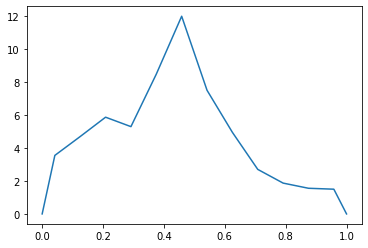

In [12]:
# Create list to store the values for each interpolated minute
all_minutes_values = []
# 
# Get the minute which each of the duration bisn refers to (is this sensical to assume these relate to a specific minutes?)
minutes = cluster['Dur_bins'] * 360

# Find the interpolated values?
y_interp = interp1d(minutes,cluster['rainfall_this_dur_bin'])

# Find the interpolated values corresponding to each minute
for i in range(0,360):
    all_minutes_values.append(y_interp(i))

# Save as dataframe
df = pd.DataFrame({'minute':range(0,360),
                   'values':all_minutes_values})


# plt.plot(df['minute'], df['values'], linestyle = 'solid')
plt.plot(cluster['Dur_bins'], cluster['rainfall_this_dur_bin'], linestyle = 'solid')


# fp = "/nfs/a319/gy17m2a/PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/MultiplePeaks/LinDyke_DataAndFigs/SyntheticEvents_preLossRemoval/6h"

# other = pd.read_csv("{}/6h_divide-time.csv".format(fp))
# other['minute'] = range(0,360)

# plt.plot(other['minute'], other['0.0'], linestyle = 'solid')
# plt.plot(df['minute'], df['values'], linestyle = 'solid')